In [ ]:
pred = [[[1,2,3,4,5],
        [1,2,3,4,5],]]

In [ ]:
import numpy as np

# 读取 .npy 文件
pred = np.load('results/long_term_forecast_test_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')

# 检查形状
print(f"预测数据的形状: {pred.shape}")

# 按列计算均值
# pred.shape = (409, 84, 5)
# 我们需要对最后一个维度（即5个列）计算均值
# mean_values = np.mean(pred, axis=(0, 1))

#这里是只取第一个(84, 5)
# 提取第一个 [84, 5] 元素
first_element = pred[0, :84, :5]

# 计算均值
mean_values = np.mean(first_element, axis=0)

# 输出结果
print(f"五个列的均值: {mean_values}")

# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 将均值通过 Sigmoid 函数进行变换
sigmoid_values = sigmoid(mean_values)

# 将变换后的值相加
sum_sigmoid_values = np.sum(sigmoid_values)

print(f"经过 Sigmoid 函数的值: {sigmoid_values}")
print(f"五个 Sigmoid 值的和: {sum_sigmoid_values}")

score = ((sum_sigmoid_values - 2.5) / 2.5) * 100
print(f"最终得分: {score}")

In [ ]:
# 十个数据集 预测分数和平均斜率计算
import numpy as np
import pandas as pd

repoName = ['vue', 'tensorflow', 'autogpt', 'kubernetes', 'terminal',
            'flutter', 'vscode', 'react-naive', 'electron', 'transformers']

# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 创建一个空的列表来存储结果
results = []

for name in repoName:
    pred = np.load(f'results/long_term_forecast_{name}_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')

    first_element = pred[0, :84, :5]

    # 计算均值
    mean_values = np.mean(first_element, axis=0)

    # 将均值通过 Sigmoid 函数进行变换
    sigmoid_values = sigmoid(mean_values)

    # 将变换后的值相加
    sum_sigmoid_values = np.sum(sigmoid_values)

    score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

    file_path = f'dataset/{name}/{name}_all_normalize_Quartiles.csv'
    df = pd.read_csv(file_path)

    # 获取数据集的长度
    dataset_len = len(df)

    # 定义参数
    num_test = int(dataset_len * 0.2)  # 测试数据的数量
    pred_len = 84   # 预测长度
    seq_len = 84    # 序列长度

    # 计算数据范围
    start_index = dataset_len - num_test
    end_index = dataset_len - num_test + pred_len

    # 提取指定范围的数据
    data_range = df.iloc[start_index:end_index]
    data_range = data_range.drop(columns=['date'])

    # 计算每个属性的累计量
    cumulative_data = data_range.cumsum()

    # 计算每个属性的总变化量
    total_changes = cumulative_data.iloc[-1] - data_range.iloc[0]

    # 计算时间步长
    time_steps = len(data_range) - 1

    # 计算每个属性的平均斜率
    slopes = total_changes / time_steps

    # 计算所有属性的平均斜率
    average_slope = slopes.mean()

    # 将结果存储到字典中
    result_dict = {'name': name, 'score': score, 'average_slope': average_slope}
    for col, slope in zip(data_range.columns, slopes):
        result_dict[col] = slope

    # 将结果字典添加到列表中
    results.append(result_dict)

# 将结果列表转换为 DataFrame 并保存到 CSV 文件中
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='score', ascending=True)
results_df.to_csv('workresult/results_summary_quartiles_averageSlope.csv', index=False)

print("结果已保存到 results_summary_quartiles_averageSlope.csv")
    

In [ ]:
# 多数据集匹配
import os
import re
import numpy as np
import pandas as pd

# 正则表达式
# 定义文件夹路径
# folder_path = 'dataset/Top_random100_from500'
folder_path = 'dataset/Bottom_random100_from500'

pattern = r"^(.*?)(?=(_all_roll_ewma_span28_normalize))"

repoName = []

# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 遍历文件夹中的文件
for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        match = re.search(pattern, filename)
        if match:
            prefix = match.group(1)
            repoName.append(prefix)

# # 打印结果
# print(len(repoName))

# 创建一个空的列表来存储结果
results = []

for name in repoName:
    try:
        pred = np.load(f'results/long_term_forecast_{name}_all_roll_ewma_span28_normalize_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')
    except FileNotFoundError:
        print(f"未找到 {name} 的预测文件，跳过...")
        continue

    first_element = pred[0, :84, :5]

    # 计算均值
    mean_values = np.mean(first_element, axis=0)

    # 将均值通过 Sigmoid 函数进行变换
    sigmoid_values = sigmoid(mean_values)

    # 将变换后的值相加
    sum_sigmoid_values = np.sum(sigmoid_values)

    score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

    # file_path = f'dataset/Top_random100_from500/{name}_all_normalize.csv'
    file_path = f'dataset/Bottom_random100_from500/{name}_all_normalize.csv'
    df = pd.read_csv(file_path)

    # 获取数据集的长度
    dataset_len = len(df)

    # 定义参数
    num_test = int(dataset_len * 0.2)  # 测试数据的数量
    pred_len = 84   # 预测长度
    seq_len = 84    # 序列长度

    # 计算数据范围
    start_index = dataset_len - num_test
    end_index = dataset_len - num_test + pred_len

    # 提取指定范围的数据
    data_range = df.iloc[start_index:end_index]
    data_range = data_range.drop(columns=['date'])

    # 计算每个属性的累计量
    cumulative_data = data_range.cumsum()

    # 计算每个属性的总变化量
    total_changes = cumulative_data.iloc[-1] - data_range.iloc[0]

    # 计算时间步长
    time_steps = len(data_range) - 1

    # 计算每个属性的平均斜率
    slopes = total_changes / time_steps

    # 计算所有属性的平均斜率
    average_slope = slopes.mean()

    # 将结果存储到字典中
    result_dict = {'name': name, 'score': score, 'average_slope': average_slope}
    for col, slope in zip(data_range.columns, slopes):
        result_dict[col] = slope

    # 将结果字典添加到列表中
    results.append(result_dict)

# 将结果列表转换为 DataFrame 并保存到 CSV 文件中
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='score', ascending=True)
results_df.to_csv('workresult/results_summary_averageSlope.csv', index=False)

print("结果已保存到 results_summary_averageSlope.csv")

In [ ]:
# language结果验证
import os
import re
import numpy as np
import pandas as pd

language = ["C","C++","Java","Python","JavaScript","TypeScript","Go","Rust","Shell","Swift","Other"]

# 假设 delete_dataset 是从 CSV 文件中读取的
delete_dataset = pd.read_csv('workresult/language/Deleted_Datasets.csv')['dataset']


    # 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for lang in language:
    folder_path = f"dataset/language/Detail_repo/{lang}"
    
    pattern = r"^(.*?)(?=(_all_roll_ewma_span28_normalize))"

    repoName = []

    # 遍历文件夹中的文件
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            match = re.search(pattern, filename)
            if match:
                prefix = match.group(1)
                if prefix not in delete_dataset.values:
                    repoName.append(prefix)
    
    # 创建一个空的列表来存储结果
    results = []

    for name in repoName:
        try:
            pred = np.load(f'results/long_term_forecast_language_{name}_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')
        except FileNotFoundError:
            print(f"未找到 {name} 的预测文件，跳过...")
            continue

        first_element = pred[0, :84, :5]

        # 计算均值
        mean_values = np.mean(first_element, axis=0)

        # 将均值通过 Sigmoid 函数进行变换
        sigmoid_values = sigmoid(mean_values)

        # 将变换后的值相加
        sum_sigmoid_values = np.sum(sigmoid_values)

        score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

        # file_path = f'dataset/Top_random100_from500/{name}_all_normalize.csv'
        file_path = f'dataset/language/Detail_repo/{lang}/{name}_all_roll_ewma_span28_normalize.csv'
        df = pd.read_csv(file_path)

        # 获取数据集的长度
        dataset_len = len(df)

        # 定义参数
        num_test = int(dataset_len * 0.2)  # 测试数据的数量
        pred_len = 84   # 预测长度
        seq_len = 84    # 序列长度

        # 计算数据范围
        start_index = dataset_len - num_test
        end_index = dataset_len - num_test + pred_len

        # 提取指定范围的数据
        data_range = df.iloc[start_index:end_index]
        data_range = data_range.drop(columns=['date'])

        # 计算每个属性的累计量
        cumulative_data = data_range.cumsum()

        # 计算每个属性的总变化量
        total_changes = cumulative_data.iloc[-1] - data_range.iloc[0]

        # 计算时间步长
        time_steps = len(data_range) - 1

        # 计算每个属性的平均斜率
        slopes = total_changes / time_steps

        # 计算所有属性的平均斜率
        average_slope = slopes.mean()

        # 将结果存储到字典中
        result_dict = {'name': name, 'score': score, 'average_slope': average_slope}
        for col, slope in zip(data_range.columns, slopes):
            result_dict[col] = slope

        # 将结果字典添加到列表中
        results.append(result_dict)

    # 将结果列表转换为 DataFrame 并保存到 CSV 文件中
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='score', ascending=True)
    results_df.to_csv(f'workresult/language/results_{lang}_averageSlope.csv', index=False)

    print(f"结果已保存到 results_{lang}_averageSlope.csv")

In [14]:
# user_type结果验证
import os
import re
import numpy as np
import pandas as pd

user_type = ["org", "person"]

# 假设 delete_dataset 是从 CSV 文件中读取的,统一从language删除的那里对应，本质上都是同一个数据集
delete_dataset = pd.read_csv('workresult/language/Deleted_Datasets.csv')['dataset']


# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for type in user_type:
    folder_path = f"dataset/user_type/Detail_repo/{type}"
    
    pattern = r"^(.*?)(?=(_all_roll_ewma_span28_normalize))"

    repoName = []

    # 遍历文件夹中的文件
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            match = re.search(pattern, filename)
            if match:
                prefix = match.group(1)
                if prefix not in delete_dataset.values:
                    repoName.append(prefix)
    
    # 创建一个空的列表来存储结果
    results = []

    for name in repoName:
        try:
            pred = np.load(f'results/long_term_forecast_language_{name}_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')
        except FileNotFoundError:
            print(f"未找到 {name} 的预测文件，跳过...")
            continue

        first_element = pred[0, :84, :5]

        # 计算均值
        mean_values = np.mean(first_element, axis=0)

        # 将均值通过 Sigmoid 函数进行变换
        sigmoid_values = sigmoid(mean_values)

        # 将变换后的值相加
        sum_sigmoid_values = np.sum(sigmoid_values)

        score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

        # file_path = f'dataset/Top_random100_from500/{name}_all_normalize.csv'
        file_path = f'dataset/user_type/Detail_repo/{type}/{name}_all_roll_ewma_span28_normalize.csv'
        df = pd.read_csv(file_path)

        # 获取数据集的长度
        dataset_len = len(df)

        # 定义参数
        num_test = int(dataset_len * 0.2)  # 测试数据的数量
        pred_len = 84   # 预测长度
        seq_len = 84    # 序列长度

        # 计算数据范围
        start_index = dataset_len - num_test
        end_index = dataset_len - num_test + pred_len

        # 提取指定范围的数据
        data_range = df.iloc[start_index:end_index]
        data_range = data_range.drop(columns=['date'])

        # 计算每个属性的累计量
        cumulative_data = data_range.cumsum()

        # 计算每个属性的总变化量
        total_changes = cumulative_data.iloc[-1] - data_range.iloc[0]

        # 计算时间步长
        time_steps = len(data_range) - 1

        # 计算每个属性的平均斜率
        slopes = total_changes / time_steps

        # 计算所有属性的平均斜率
        average_slope = slopes.mean()

        # 将结果存储到字典中
        result_dict = {'name': name, 'score': score, 'average_slope': average_slope}
        for col, slope in zip(data_range.columns, slopes):
            result_dict[col] = slope

        # 将结果字典添加到列表中
        results.append(result_dict)

    # 将结果列表转换为 DataFrame 并保存到 CSV 文件中
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='score', ascending=True)
    results_df.to_csv(f'workresult/user_type/results_{type}_averageSlope.csv', index=False)

    print(f"结果已保存到 results_{type}_averageSlope.csv")

未找到 spark 的预测文件，跳过...
未找到 remix 的预测文件，跳过...
未找到 metabase 的预测文件，跳过...
未找到 gitlabhq 的预测文件，跳过...
未找到 guzzle 的预测文件，跳过...
未找到 SDWebImage 的预测文件，跳过...
未找到 Awesome 的预测文件，跳过...
未找到 iosched 的预测文件，跳过...
未找到 project-based-learning 的预测文件，跳过...
未找到 fastText 的预测文件，跳过...
未找到 eShopOnContainers 的预测文件，跳过...
未找到 huginn 的预测文件，跳过...
未找到 vue-devtools 的预测文件，跳过...
未找到 Microsoft-Activation-Scripts 的预测文件，跳过...
未找到 streisand 的预测文件，跳过...
未找到 en.javascript.info 的预测文件，跳过...
未找到 every-programmer-should-know 的预测文件，跳过...
未找到 copilot-docs 的预测文件，跳过...
未找到 bun 的预测文件，跳过...
未找到 first-contributions 的预测文件，跳过...
未找到 symfony 的预测文件，跳过...
未找到 forem 的预测文件，跳过...
未找到 FFmpeg 的预测文件，跳过...
未找到 carbon-lang 的预测文件，跳过...
未找到 gitignore 的预测文件，跳过...
未找到 appflowy 的预测文件，跳过...
未找到 stable-diffusion 的预测文件，跳过...
未找到 postgrest 的预测文件，跳过...
未找到 freecodecamp.cn 的预测文件，跳过...
未找到 brackets 的预测文件，跳过...
未找到 aspnetcore 的预测文件，跳过...
未找到 discourse 的预测文件，跳过...
未找到 awesome-vue 的预测文件，跳过...
未找到 rails 的预测文件，跳过...
未找到 fastlane 的预测文件，跳过...
未找到 fastai 的预测文件，跳过...
未找到 run

In [ ]:
# license结果验证
import os
import re
import numpy as np
import pandas as pd

user_type = ["AGPL3.0", "Apache2.0", "BSD3-Clause", "MIT", "CC0", "GPL3.0", "Other"]

# 假设 delete_dataset 是从 CSV 文件中读取的,统一从language删除的那里对应，本质上都是同一个数据集
delete_dataset = pd.read_csv('workresult/language/Deleted_Datasets.csv')['dataset']


# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for type in user_type:
    folder_path = f"dataset/user_type/{type}"
    
    pattern = r"^(.*?)(?=(_all_roll_ewma_span28_normalize))"

    repoName = []

    # 遍历文件夹中的文件
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            match = re.search(pattern, filename)
            if match:
                prefix = match.group(1)
                if prefix not in delete_dataset.values:
                    repoName.append(prefix)
    
    # 创建一个空的列表来存储结果
    results = []

    for name in repoName:
        try:
            pred = np.load(f'results/long_term_forecast_language_{name}_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')
        except FileNotFoundError:
            print(f"未找到 {name} 的预测文件，跳过...")
            continue

        first_element = pred[0, :84, :5]

        # 计算均值
        mean_values = np.mean(first_element, axis=0)

        # 将均值通过 Sigmoid 函数进行变换
        sigmoid_values = sigmoid(mean_values)

        # 将变换后的值相加
        sum_sigmoid_values = np.sum(sigmoid_values)

        score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

        # file_path = f'dataset/Top_random100_from500/{name}_all_normalize.csv'
        file_path = f'dataset/user_type/Detail_repo/{type}/{name}_all_roll_ewma_span28_normalize.csv'
        df = pd.read_csv(file_path)

        # 获取数据集的长度
        dataset_len = len(df)

        # 定义参数
        num_test = int(dataset_len * 0.2)  # 测试数据的数量
        pred_len = 84   # 预测长度
        seq_len = 84    # 序列长度

        # 计算数据范围
        start_index = dataset_len - num_test
        end_index = dataset_len - num_test + pred_len

        # 提取指定范围的数据
        data_range = df.iloc[start_index:end_index]
        data_range = data_range.drop(columns=['date'])

        # 计算每个属性的累计量
        cumulative_data = data_range.cumsum()

        # 计算每个属性的总变化量
        total_changes = cumulative_data.iloc[-1] - data_range.iloc[0]

        # 计算时间步长
        time_steps = len(data_range) - 1

        # 计算每个属性的平均斜率
        slopes = total_changes / time_steps

        # 计算所有属性的平均斜率
        average_slope = slopes.mean()

        # 将结果存储到字典中
        result_dict = {'name': name, 'score': score, 'average_slope': average_slope}
        for col, slope in zip(data_range.columns, slopes):
            result_dict[col] = slope

        # 将结果字典添加到列表中
        results.append(result_dict)

    # 将结果列表转换为 DataFrame 并保存到 CSV 文件中
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='score', ascending=True)
    results_df.to_csv(f'workresult/user_type/results_{type}_averageSlope.csv', index=False)

    print(f"结果已保存到 results_{type}_averageSlope.csv")

In [ ]:
# 十个数据集 预测分数和CAGR计算
import numpy as np
import pandas as pd

repoName = ['vue', 'tensorflow', 'autogpt', 'kubernetes', 'terminal',
            'flutter', 'vscode', 'react-naive', 'electron', 'transformers']

# 定义 Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 创建一个空的列表来存储结果
results = []

for name in repoName:
    pred = np.load(f'results/long_term_forecast_{name}_84_84_PatchTST_custom_ftM_sl84_ll84_pl84_dm512_nh2_el1_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')

    first_element = pred[0, :84, :5]

    # 计算均值
    mean_values = np.mean(first_element, axis=0)

    # 将均值通过 Sigmoid 函数进行变换
    sigmoid_values = sigmoid(mean_values)

    # 将变换后的值相加
    sum_sigmoid_values = np.sum(sigmoid_values)

    score = ((sum_sigmoid_values - 2.5) / 2.5) * 100

    file_path = f'dataset/{name}/{name}_all_normalize.csv'
    df = pd.read_csv(file_path)

    # 获取数据集的长度
    dataset_len = len(df)

    # 定义参数
    num_test = int(dataset_len * 0.2)  # 测试数据的数量
    pred_len = 84   # 预测长度
    seq_len = 84    # 序列长度

    # 计算数据范围
    start_index = dataset_len - num_test
    end_index = dataset_len - num_test + pred_len

    # 提取指定范围的数据
    data_range = df.iloc[start_index:end_index]
    data_range = data_range.drop(columns=['date'])

    # 计算每个属性的初始值和最终值
    initial_values = data_range.iloc[0]
    final_values = data_range.iloc[-1]

    # 计算时间周期（年）
    time_period_years = (len(data_range) - 1) / 365  # 假设数据是按天记录的

    # 计算每个属性的CAGR
    cagr = (final_values / initial_values) ** (1 / time_period_years) - 1

    # 计算所有属性的平均CAGR
    average_cagr = cagr.mean()

    # 将结果存储到字典中
    result_dict = {'name': name, 'score': score, 'average_cagr': average_cagr}
    for col, cagr_value in zip(data_range.columns, cagr):
        result_dict[col] = cagr_value

    # 将结果字典添加到列表中
    results.append(result_dict)

# 将结果列表转换为 DataFrame 并保存到 CSV 文件中
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='score', ascending=True)
results_df.to_csv('workresult/results_summary_CAGR.csv', index=False)

print("结果已保存到 results_summary_CAGR.csv")

In [ ]:
# language 结果绘图
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

language = ["C","C++","Java","Python","JavaScript","TypeScript","Go","Rust","Shell","Swift","Other"]
degrees = [1, 3]

for lang in language:
    # 读取CSV文件
    file_path = f'workresult/language/results_{lang}_averageSlope.csv'  # 替换为你的CSV文件路径
    df = pd.read_csv(file_path)

    # 过滤掉 score 列为空或缺失值的数据点
    df = df.dropna(subset=['score'])

    # 提取所需的列
    scores = df['score'].values.reshape(-1, 1)
    average_slopes = df['average_slope']

    for degree in degrees:
        # 创建多项式特征
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(scores)

        # 训练多项式回归模型
        model = LinearRegression()
        model.fit(X_poly, average_slopes)

        # 生成拟合曲线的数据点
        x_line = np.linspace(min(scores), max(scores), 100).reshape(-1, 1)
        X_line_poly = poly.transform(x_line)
        y_line = model.predict(X_line_poly)

        # 绘制散点图和拟合曲线
        plt.scatter(scores, average_slopes, label='Data Points')
        plt.plot(x_line, y_line, color='red', label=f'Best Fit Curve (Degree {degree})')

        # 添加标题和标签
        plt.title(f'{lang} Best Fit Curve')
        plt.xlabel('Score')
        plt.ylabel('Average Slope')
        plt.legend()

        # 显示图形
        plt.show()

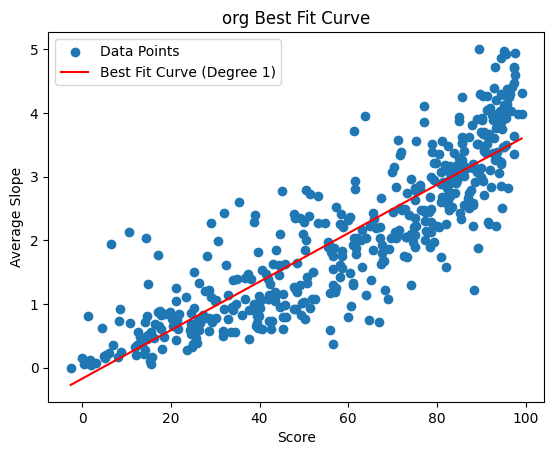

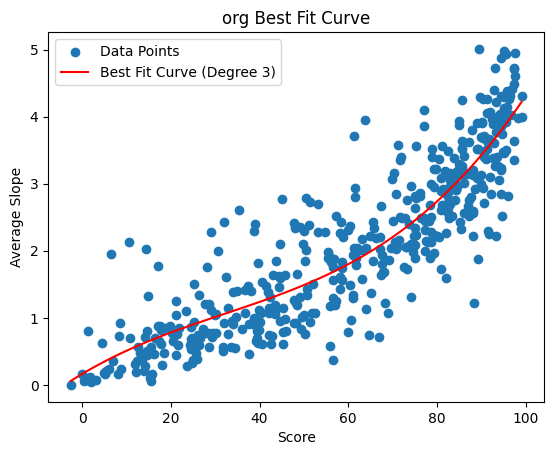

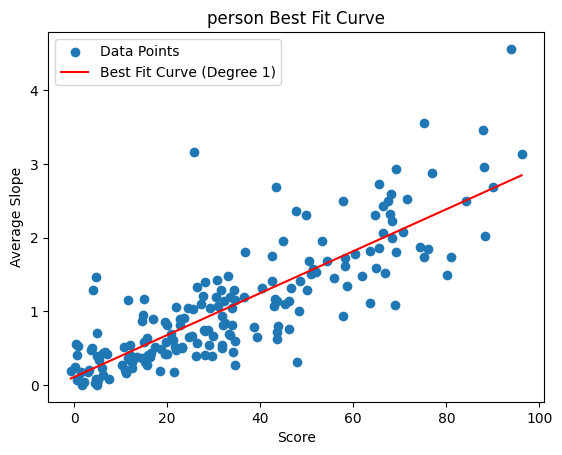

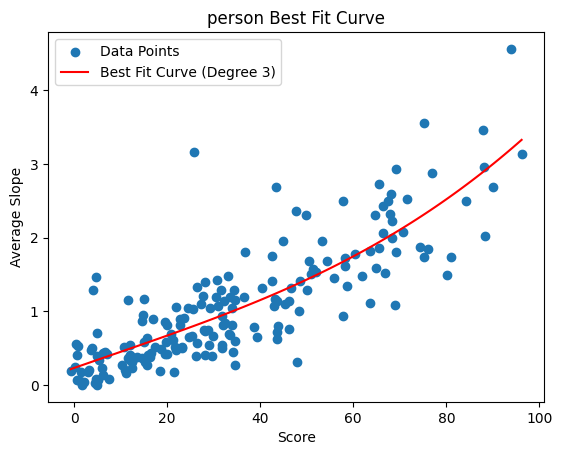

In [15]:
# user_type 结果绘图
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

user_type = ['org', 'person']
degrees = [1, 3]

for type in user_type:
    # 读取CSV文件
    file_path = f'workresult/user_type/results_{type}_averageSlope.csv'  # 替换为你的CSV文件路径
    df = pd.read_csv(file_path)

    # 过滤掉 score 列为空或缺失值的数据点
    df = df.dropna(subset=['score'])

    # 提取所需的列
    scores = df['score'].values.reshape(-1, 1)
    average_slopes = df['average_slope']

    for degree in degrees:
        # 创建多项式特征
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(scores)

        # 训练多项式回归模型
        model = LinearRegression()
        model.fit(X_poly, average_slopes)

        # 生成拟合曲线的数据点
        x_line = np.linspace(min(scores), max(scores), 100).reshape(-1, 1)
        X_line_poly = poly.transform(x_line)
        y_line = model.predict(X_line_poly)

        # 绘制散点图和拟合曲线
        plt.scatter(scores, average_slopes, label='Data Points')
        plt.plot(x_line, y_line, color='red', label=f'Best Fit Curve (Degree {degree})')

        # 添加标题和标签
        plt.title(f'{type} Best Fit Curve')
        plt.xlabel('Score')
        plt.ylabel('Average Slope')
        plt.legend()

        # 显示图形
        plt.show()

In [ ]:
# 公式结果的可视化验证
import pandas as pd
import matplotlib.pyplot as plt


# 读取 CSV 文件
file_path = 'dataset/transformers/transformers_all.csv'
df = pd.read_csv(file_path)

# 获取数据集的长度
dataset_len = len(df)

# 定义参数
num_test = int(dataset_len * 0.2)  # 测试数据的数量
pred_len = 84   # 预测长度
seq_len = 84    # 序列长度

# 计算数据范围
start_index = dataset_len - num_test - seq_len
end_index = dataset_len - num_test + pred_len

print('start_index:', start_index)

# 提取指定范围的数据
data_range = df.iloc[start_index:end_index]

# 除 date 列外的所有列
columns_to_plot = data_range.columns[1:]

# 创建一个图形窗口
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(14, 5 * len(columns_to_plot)))

# 如果只有一个子图，将其转换为列表
if len(columns_to_plot) == 1:
    axes = [axes]

# 绘制每个属性的数据
for ax, column in zip(axes, columns_to_plot):
    ax.plot(data_range['date'], data_range[column], label=column)
    ax.axvline(x=df['date'].iloc[dataset_len - num_test], color='r', linestyle='--', linewidth=1, label='Test Start')
    ax.set_title(f'{column} Data Visualization')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [ ]:
# MIC 验证
import pandas as pd
from minepy import MINE

# 读取本地文件（假设文件名为 'data.csv'）
file_path = 'workresult/results_summary_averageSlope.csv'  # 将此路径替换为你的文件路径
data = pd.read_csv(file_path)

# 检查文件是否包含 'score' 列
if 'score' not in data.columns:
    raise ValueError("文件中缺少 'score' 列，请检查文件内容。")

# 获取除 'date' 外的所有列
columns_to_check = [col for col in data.columns if col != 'name' and col != 'score']

# 初始化 MINE 对象
mine = MINE()

# 存储 MIC 值
mic_values = {}

# 计算每个列与 'score' 之间的 MIC 值
for column in columns_to_check:
    mine.compute_score(data['score'], data[column])
    mic_values[column] = mine.mic()

# 打印结果
for column, mic_value in mic_values.items():
    print(f"MIC between 'score' and '{column}': {mic_value}")

In [ ]:
# 计算pearson和spearman相关系数
# 导入必要的库
import pandas as pd
import numpy as np

# 读取本地文件（假设文件名为 'data.csv'）
file_path = 'workresult/Bottom100_random_roll_ewma_normalize/results_summary_averageSlope.csv'  # 将此路径替换为你的文件路径
data = pd.read_csv(file_path)

# 检查文件是否包含 'score' 列
if 'score' not in data.columns:
    raise ValueError("文件中缺少 'score' 列，请检查文件内容。")

# 过滤掉 score 列为空或缺失值的行
data = data.dropna(subset=['score'])

# 获取除 'name' 和 'score' 外的所有列
columns_to_check = [col for col in data.columns if col != 'name' and col != 'score']

# 存储  Pearson 相关系数
pearson_correlations = {}
spearman_correlations = {}

# 计算每个列与 'score' 之间的 Pearson 相关系数
for column in columns_to_check:
    # 计算 Pearson 相关系数
    pearson_correlation = data['score'].corr(data[column], method='pearson')
    pearson_correlations[column] = pearson_correlation

    # 计算 Spearman 相关系数
    spearman_correlation = data['score'].corr(data[column], method='spearman')
    spearman_correlations[column] = spearman_correlation


print("\nPearson correlations:")
for column, pearson_corr in pearson_correlations.items():
    print(f"Pearson correlation between 'score' and '{column}': {pearson_corr}")

print("\nSpearman correlations:")
for column, spearman_corr in spearman_correlations.items():
    print(f"Spearman correlation between 'score' and '{column}': {spearman_corr}")